# Tabular Playground Series March 2022

The goal is to predict the congestion on each road.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting
from scipy import stats # statistics
import statsmodels.api as sm #ARIMA filter

# Matplotlib defaults
plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
      titleweight='bold', titlesize=18, titlepad=10)
plt.rcParams['figure.figsize'] = [18,10]

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-mar-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-mar-2022/train.csv
/kaggle/input/tabular-playground-series-mar-2022/test.csv


## Data Exploration

In [2]:
data_set = pd.read_csv("/kaggle/input/tabular-playground-series-mar-2022/train.csv")
data_set.head(20)

,row_id,time,x,y,direction,congestion
0,0,1991-04-01 00:00:00,0,0,EB,70
1,1,1991-04-01 00:00:00,0,0,NB,49
2,2,1991-04-01 00:00:00,0,0,SB,24
3,3,1991-04-01 00:00:00,0,1,EB,18
4,4,1991-04-01 00:00:00,0,1,NB,60
5,5,1991-04-01 00:00:00,0,1,SB,58
6,6,1991-04-01 00:00:00,0,1,WB,26
7,7,1991-04-01 00:00:00,0,2,EB,31
8,8,1991-04-01 00:00:00,0,2,NB,49
9,9,1991-04-01 00:00:00,0,2,SB,46


In [3]:
data_set.describe()

,row_id,x,y,congestion
count,848835.00000,848835.000000,848835.000000,848835.000000
mean,424417.00000,1.138462,1.630769,47.815305
std,245037.70221,0.801478,1.089379,16.799392
min,0.00000,0.000000,0.000000,0.000000
25%,212208.50000,0.000000,1.000000,35.000000
50%,424417.00000,1.000000,2.000000,47.000000
75%,636625.50000,2.000000,3.000000,60.000000
max,848834.00000,2.000000,3.000000,100.000000


Firstly there is no missing values, so no data cleaning is required.

#### Data
* row_id: unquie identifier for each entry.
* time: The time when the entry was recorded, taken perodically every 20 minutes.
* x,y: The co-ordinates of the point on the road.
* direction: The direction the traffic is headed from the co-ordinate. Has 8 possible directions
* congestion: A measure of the amount of traffic, ranges from 0 (none) to 100 (gridlock)

Firstly the co-ordinate pair is reduced to a single unquie value for each possible pairing. Since the set of x {0,1,2} and y {0,1,2,3} we use the simple encoding of coord symbol = 10*x + y to unquiely display each pair. Thus for x=1 and y=2, then coord_sym = 12

In [4]:
data_set['coord_sym'] = 10*data_set['x'] + data_set['y']
unique_coords = data_set['coord_sym'].unique()

print("Unquie coordinate pairs: ", unique_coords)
print("Total number of coordinates: ", unique_coords.shape[0])

Unquie coordinate pairs:  [ 0  1  2  3 10 11 12 13 20 21 22 23]
Total number of coordinates:  12


Create dataframe for each coordinate

In [5]:
df_00 = data_set[data_set["coord_sym"]==0]
df_01 = data_set[data_set["coord_sym"]==1]
df_02 = data_set[data_set["coord_sym"]==2]
df_03 = data_set[data_set["coord_sym"]==3]

df_10 = data_set[data_set["coord_sym"]==10]
df_11 = data_set[data_set["coord_sym"]==11]
df_12 = data_set[data_set["coord_sym"]==12]
df_13 = data_set[data_set["coord_sym"]==13]

df_20 = data_set[data_set["coord_sym"]==20]
df_21 = data_set[data_set["coord_sym"]==21]
df_22 = data_set[data_set["coord_sym"]==22]
df_23 = data_set[data_set["coord_sym"]==23]

#print("Size of df_00: ",df_00.shape[0])
#print("Size of df_01: ",df_01.shape[0])
#print("Size of df_02: ",df_02.shape[0])
#print("Size of df_03: ",df_03.shape[0])

#print("Size of df_10: ",df_10.shape[0])
#print("Size of df_11: ",df_11.shape[0])
#print("Size of df_12: ",df_12.shape[0])
#print("Size of df_13: ",df_13.shape[0])

#print("Size of df_20: ",df_20.shape[0])
#print("Size of df_21: ",df_21.shape[0])
#print("Size of df_22: ",df_22.shape[0])
#print("Size of df_23: ",df_23.shape[0])

Get the possible exit path for each coordinate and thus get each entry path based on surrounding coordinates exit paths. 

In [6]:
uni_dir_00 = df_00["direction"].unique()
print("There are: ",uni_dir_00.shape[0]," directions for df_00, which are: (",uni_dir_00,")")
uni_dir_01 = df_01["direction"].unique()
print("There are: ",uni_dir_01.shape[0]," directions for df_01, which are: (",uni_dir_01,")")
uni_dir_02 = df_02["direction"].unique()
print("There are: ",uni_dir_02.shape[0]," directions for df_02, which are: (",uni_dir_02,")")
uni_dir_03 = df_03["direction"].unique()
print("There are: ",uni_dir_03.shape[0]," directions for df_03, which are: (",uni_dir_03,")")

uni_dir_10 = df_10["direction"].unique()
print("There are: ",uni_dir_10.shape[0]," directions for df_10, which are: (",uni_dir_10,")")
uni_dir_11 = df_11["direction"].unique()
print("There are: ",uni_dir_11.shape[0]," directions for df_11, which are: (",uni_dir_11,")")
uni_dir_12 = df_12["direction"].unique()
print("There are: ",uni_dir_12.shape[0]," directions for df_12, which are: (",uni_dir_12,")")
uni_dir_13 = df_13["direction"].unique()
print("There are: ",uni_dir_13.shape[0]," directions for df_13, which are: (",uni_dir_13,")")

uni_dir_20 = df_20["direction"].unique()
print("There are: ",uni_dir_20.shape[0]," directions for df_20, which are: (",uni_dir_20,")")
uni_dir_21 = df_21["direction"].unique()
print("There are: ",uni_dir_21.shape[0]," directions for df_21, which are: (",uni_dir_21,")")
uni_dir_22 = df_22["direction"].unique()
print("There are: ",uni_dir_22.shape[0]," directions for df_22, which are: (",uni_dir_22,")")
uni_dir_23 = df_23["direction"].unique()
print("There are: ",uni_dir_23.shape[0]," directions for df_23, which are: (",uni_dir_23,")")

There are:  3  directions for df_00, which are: ( ['EB' 'NB' 'SB'] )
There are:  4  directions for df_01, which are: ( ['EB' 'NB' 'SB' 'WB'] )
There are:  4  directions for df_02, which are: ( ['EB' 'NB' 'SB' 'WB'] )
There are:  6  directions for df_03, which are: ( ['EB' 'NB' 'NE' 'SB' 'SW' 'WB'] )
There are:  6  directions for df_10, which are: ( ['EB' 'NB' 'NE' 'SB' 'SW' 'WB'] )
There are:  4  directions for df_11, which are: ( ['EB' 'NB' 'SB' 'WB'] )
There are:  6  directions for df_12, which are: ( ['EB' 'NB' 'NE' 'SB' 'SW' 'WB'] )
There are:  6  directions for df_13, which are: ( ['EB' 'NB' 'NE' 'SB' 'SW' 'WB'] )
There are:  4  directions for df_20, which are: ( ['EB' 'NB' 'SB' 'WB'] )
There are:  8  directions for df_21, which are: ( ['EB' 'NB' 'NE' 'NW' 'SB' 'SE' 'SW' 'WB'] )
There are:  8  directions for df_22, which are: ( ['EB' 'NB' 'NE' 'NW' 'SB' 'SE' 'SW' 'WB'] )
There are:  6  directions for df_23, which are: ( ['EB' 'NB' 'NE' 'SB' 'SW' 'WB'] )


From the above we select coordinate 00 as if has the smallest amount of connections (5):

#### Exiting(3)
* East
* North
* South

#### Entering (2)
* East (coordinate 10 westwards flow)
* North (coordinate 01 southwards flow)

Note that there are 3 measurements every hour. Thus k = 3 measurements/hour * 24 hours = 72 measurements a day, with the 73rd measuremnt being the start of the next day.

This gives 504 measurements a week and very roughly 2160 measurements per month.
A total of 13 059 measuremnts were taken, which is just over 181 days or about half a year.

Total number of traffic measurements 13059


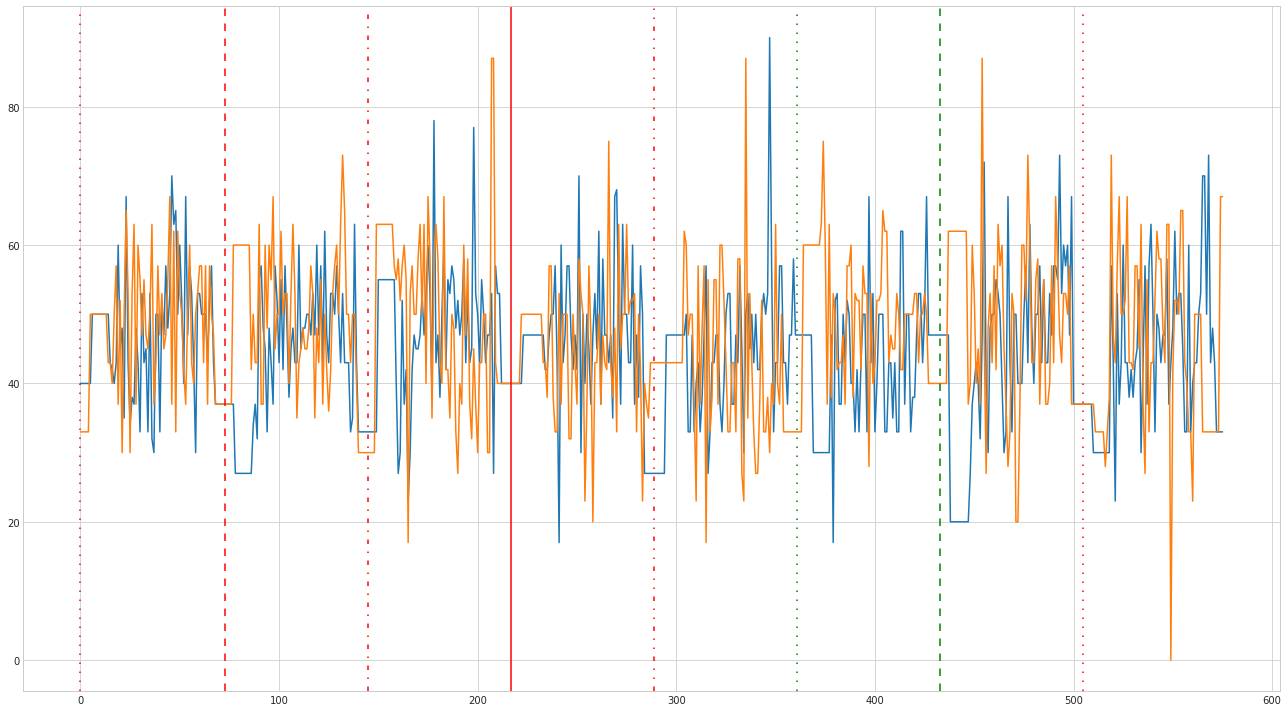

In [7]:
k=3*24 # 72 A day
w = k*7 #504 a week
wk = w+k # 576 a week and a day

df_00_eb = df_00[df_00["direction"]=="EB"]
N = df_00_eb.shape[0]
print("Total number of traffic measurements",N)

num_points = k*8 
#plt.plot(range(num_points),df_00_eb.iloc[0:num_points]['congestion'])
plt.plot(range(num_points),df_00_eb.iloc[num_points:num_points*2]['congestion'])
plt.plot(range(num_points),df_00_eb.iloc[num_points*2:num_points*3]['congestion'])
plt.axvline(x=0, color='red', linestyle=(0,(1,5)))
plt.axvline(x=k+1, color='red', linestyle=(0,(5,5)))
plt.axvline(x=2*k+1, color='red', linestyle=(0,(3,5,1,5)))
plt.axvline(x=3*k+1, color='red', linestyle='solid')
plt.axvline(x=4*k+1, color='red', linestyle=(0,(3,5,1,5,1,5)))

plt.axvline(x=5*k+1, color='green', linestyle=(0,(1,5)))
plt.axvline(x=6*k+1, color='green', linestyle=(0,(5,5)))
plt.axvline(x=7*k+1, color='red', linestyle=(0,(1,5)))

#df_00_eb['time'] = pd.to_datetime(df_00_eb['time']).astype(int)/ 10**9

#print(df_00_eb.shape)
#df_00_eb.head()

In [8]:
#plt.plot(range(num_points),df_00_eb.iloc[0:num_points]['congestion'].diff())
x = df_00_eb.iloc[0:num_points]['congestion'].diff()
x = x.iloc[1:num_points]
print(x.diff)

<bound method Series.diff of 65        0.0
130       0.0
195       0.0
260       0.0
325       0.0
         ... 
37115     4.0
37180   -17.0
37245     0.0
37310     0.0
37375     0.0
Name: congestion, Length: 575, dtype: float64>


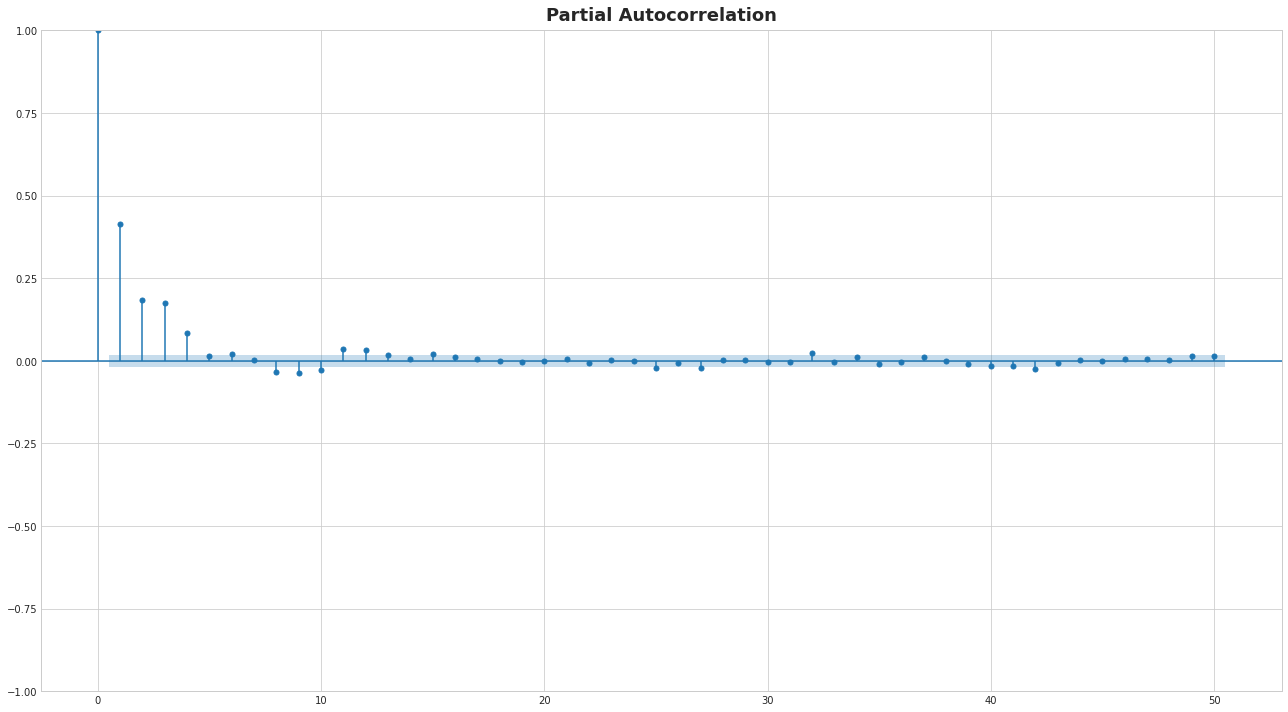

In [9]:
sm.graphics.tsa.plot_pacf(df_00_eb['congestion'], method='ywm', lags=50)
#sm.graphics.tsa.plot_pacf(x, method='ywm', lags=50)
plt.show()

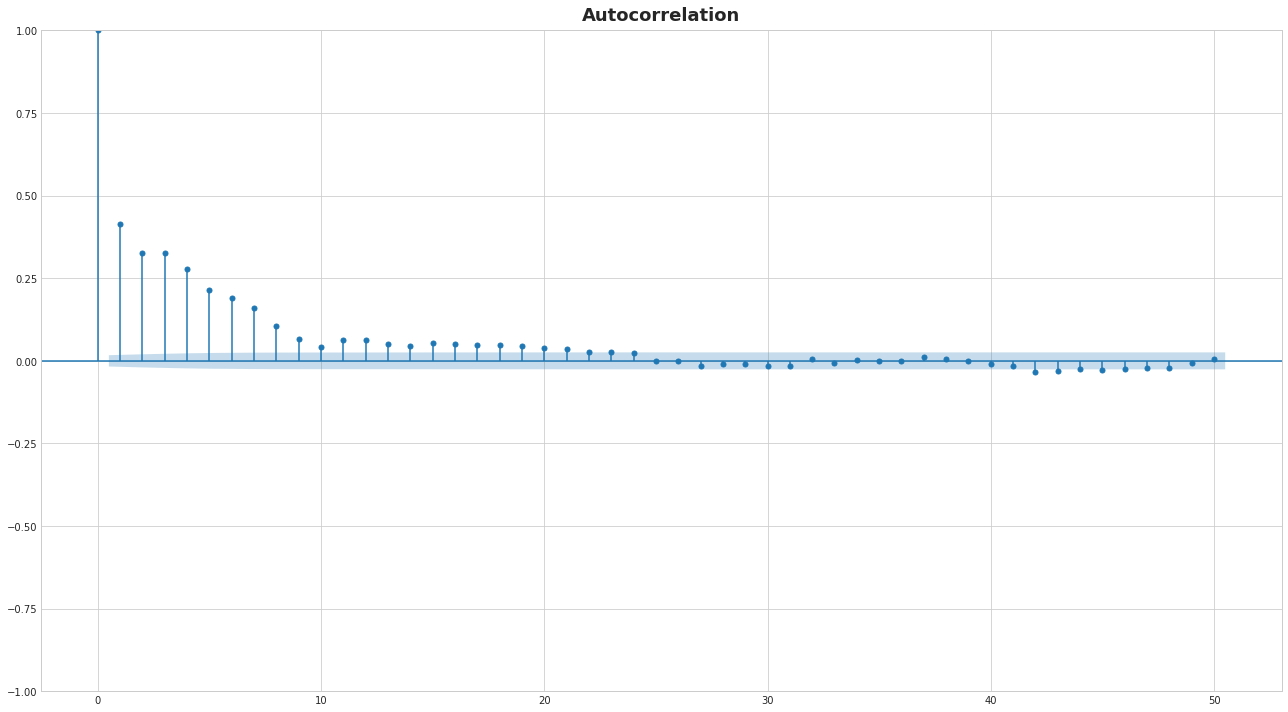

In [10]:
sm.graphics.tsa.plot_acf(df_00_eb['congestion'], lags=50)
#sm.graphics.tsa.plot_acf(x, lags=50)
plt.show()

Do not difference. p = 4, d= 0, let q=4

In [11]:
mod = sm.tsa.statespace.SARIMAX(df_00_eb.iloc[0:num_points]['congestion'], trend='c', order=(4,0,4))
res = mod.fit(disp=False)
print(res.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:591: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:591: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             congestion   No. Observations:                  576
Model:               SARIMAX(4, 0, 4)   Log Likelihood               -2172.777
Date:                Mon, 04 Apr 2022   AIC                           4365.554
Time:                        10:48:34   BIC                           4409.115
Sample:                             0   HQIC                          4382.542
                                - 576                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     16.2669      6.119      2.658      0.008       4.273      28.260
ar.L1          0.2441      0.382      0.639      0.523      -0.504       0.993
ar.L2         -0.0220      0.346     -0.063      0.9

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.80438D+00    |proj g|=  9.09518D-02


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:591: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:591: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
 This problem is unconstrained.



At iterate    5    f=  3.79995D+00    |proj g|=  1.36217D-02

At iterate   10    f=  3.79793D+00    |proj g|=  3.79075D-02

At iterate   15    f=  3.78316D+00    |proj g|=  5.30754D-02

At iterate   20    f=  3.77872D+00    |proj g|=  3.53648D-02

At iterate   25    f=  3.77771D+00    |proj g|=  5.27252D-03

At iterate   30    f=  3.77767D+00    |proj g|=  2.71559D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     49      1     0     0   2.716D-05   3.778D+00
  F =   3.7776715991854308     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


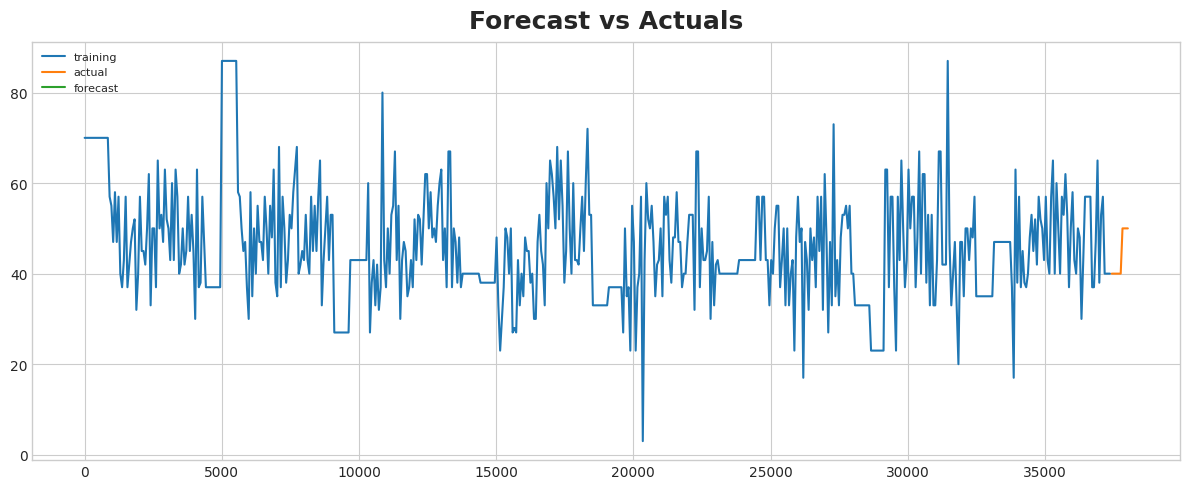

In [12]:
# Create Training and Test
train = df_00_eb.iloc[0:num_points]['congestion']
test = df_00_eb.iloc[num_points:num_points+10]['congestion']

# Build Model
model = sm.tsa.statespace.SARIMAX(train, trend='c', order=(1,0,1)) 
fitted = model.fit()  

# Forecast
forecast = fitted.get_forecast(10, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(forecast.predicted_mean, index=test.index)
conf = forecast.conf_int(alpha=0.05)
lower_series = pd.Series(conf.iloc[:,0], index=test.index)
upper_series = pd.Series(conf.iloc[:,1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [13]:
fc_series

37440   NaN
37505   NaN
37570   NaN
37635   NaN
37700   NaN
37765   NaN
37830   NaN
37895   NaN
37960   NaN
38025   NaN
Name: predicted_mean, dtype: float64

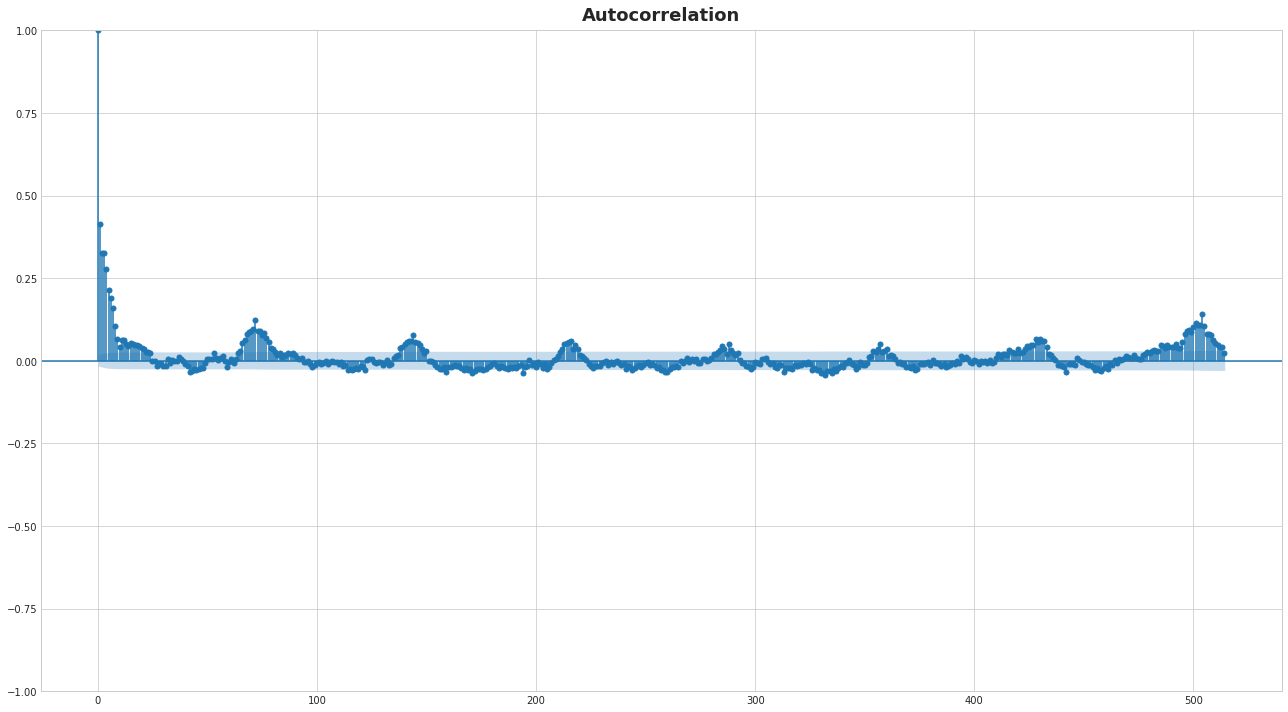

In [14]:
fig = sm.graphics.tsa.plot_acf(df_00_eb.iloc[0:]['congestion'], lags=k*7+10)

In [15]:
#temp_cross = sm.tsa.stattools.acf(df_00_eb.iloc[0:w]['congestion'], df_00_eb.iloc[0:w]['congestion'])

#plt.plot(range(w),temp_cross)

In [16]:
train_num = int(N*.8)

mod = sm.tsa.statespace.SARIMAX(df_00_eb['congestion'], trend='c', order=(1,0,0))
eb00_mod = mod.fit()
eb00_mod.summary()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:591: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:591: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85445D+00    |proj g|=  7.87448D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      8      1     0     0   4.537D-05   3.854D+00
  F =   3.8544540640649938     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             congestion   No. Observations:                13059
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -50335.316
Date:                Mon, 04 Apr 2022   AIC                         100676.631
Time:                        10:48:38   BIC                         100699.063
Sample:                             0   HQIC                        100684.125
                              - 13059                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     27.7264      0.341     81.319      0.000      27.058      28.395
ar.L1          0.4150      0.007     63.293      0.000       0.402       0.428
sigma2       130.4339      1.375     94.859      0.000     127.739     133.129
===================================================================================
Ljung-Box (L1) (Q):                  77.44   Jarque-Bera (JB):              1111.58
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             0.43
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
#nfore = 3
#forecasts = {}
#idx = pd.Index(range(0, N, 1))
#df_00_eb = df_00_eb.set_index(idx)

#for i in range(train_num, N):
#    # Update the results by appending the next observation
#    updated_value = df_00_eb.iloc[i:i+1]['congestion']
#    eb00_mod = eb00_mod.append(updated_value, refit=False)

    # Save the new set of forecasts
#    eb00_fore[updated_value.index[0]] = eb00_mod.forecast(steps=nfore)

# Combine all forecasts into a dataframe
#eb00_fore = pd.concat(eb00_fore, axis=1)

In [18]:
df_00_sb = df_00[df_00["direction"]=="SB"]
print(df_00_sb.shape)
df_00_sb.head(10)

(13059, 7)


,row_id,time,x,y,direction,congestion,coord_sym
2,2,1991-04-01 00:00:00,0,0,SB,24,0
67,67,1991-04-01 00:20:00,0,0,SB,24,0
132,132,1991-04-01 00:40:00,0,0,SB,24,0
197,197,1991-04-01 01:00:00,0,0,SB,24,0
262,262,1991-04-01 01:20:00,0,0,SB,24,0
327,327,1991-04-01 01:40:00,0,0,SB,24,0
392,392,1991-04-01 02:00:00,0,0,SB,65,0
457,457,1991-04-01 02:20:00,0,0,SB,65,0
522,522,1991-04-01 02:40:00,0,0,SB,65,0
587,587,1991-04-01 03:00:00,0,0,SB,65,0


In [19]:
df_01_sb = df_01[df_01["direction"]=="SB"]
print(df_01_sb.shape)
df_01_sb.head()

(13059, 7)


,row_id,time,x,y,direction,congestion,coord_sym
5,5,1991-04-01 00:00:00,0,1,SB,58,1
70,70,1991-04-01 00:20:00,0,1,SB,55,1
135,135,1991-04-01 00:40:00,0,1,SB,57,1
200,200,1991-04-01 01:00:00,0,1,SB,46,1
265,265,1991-04-01 01:20:00,0,1,SB,83,1


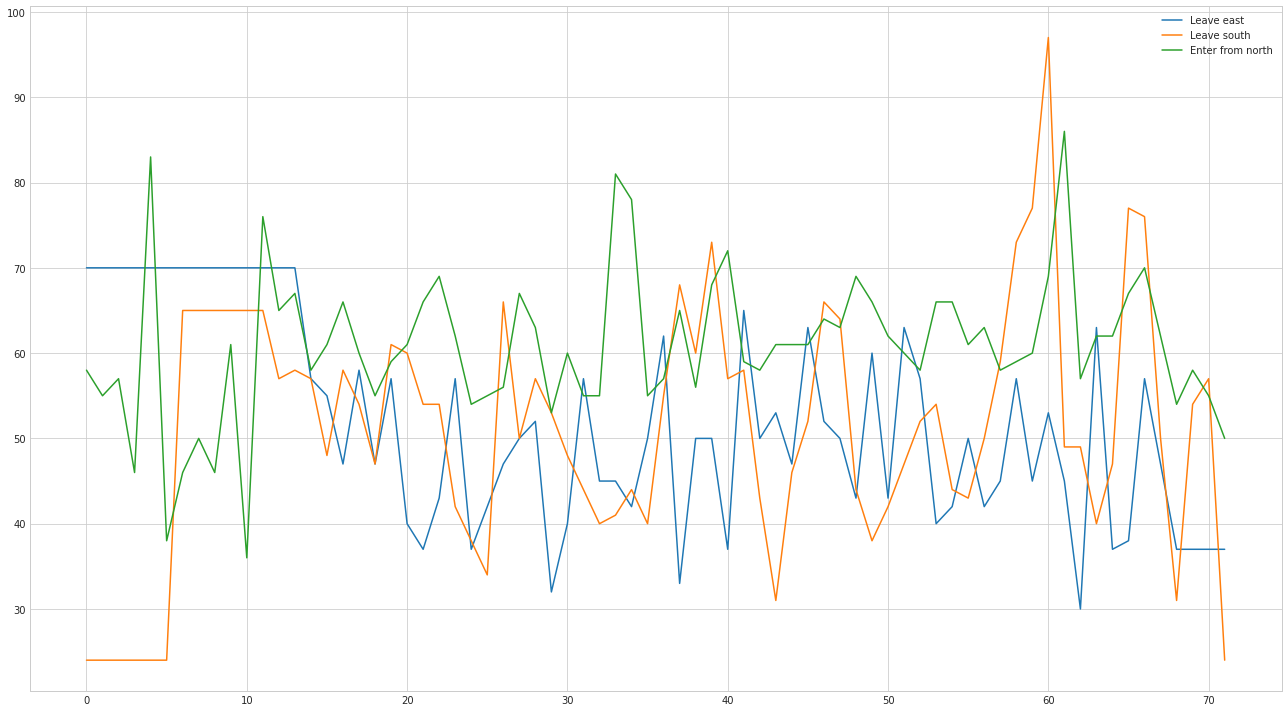

In [20]:
k = 24*3
x1 = df_00_eb['congestion'][0:k]#[k+1:2*k+1]#
x2 = df_00_sb['congestion'][0:k]
x3 = df_01_sb['congestion'][0:k]

plt.plot(range(k),x1,label='Leave east')
plt.plot(range(k),x2,label='Leave south')
plt.plot(range(k),x3,label='Enter from north')

plt.legend()
plt.show()


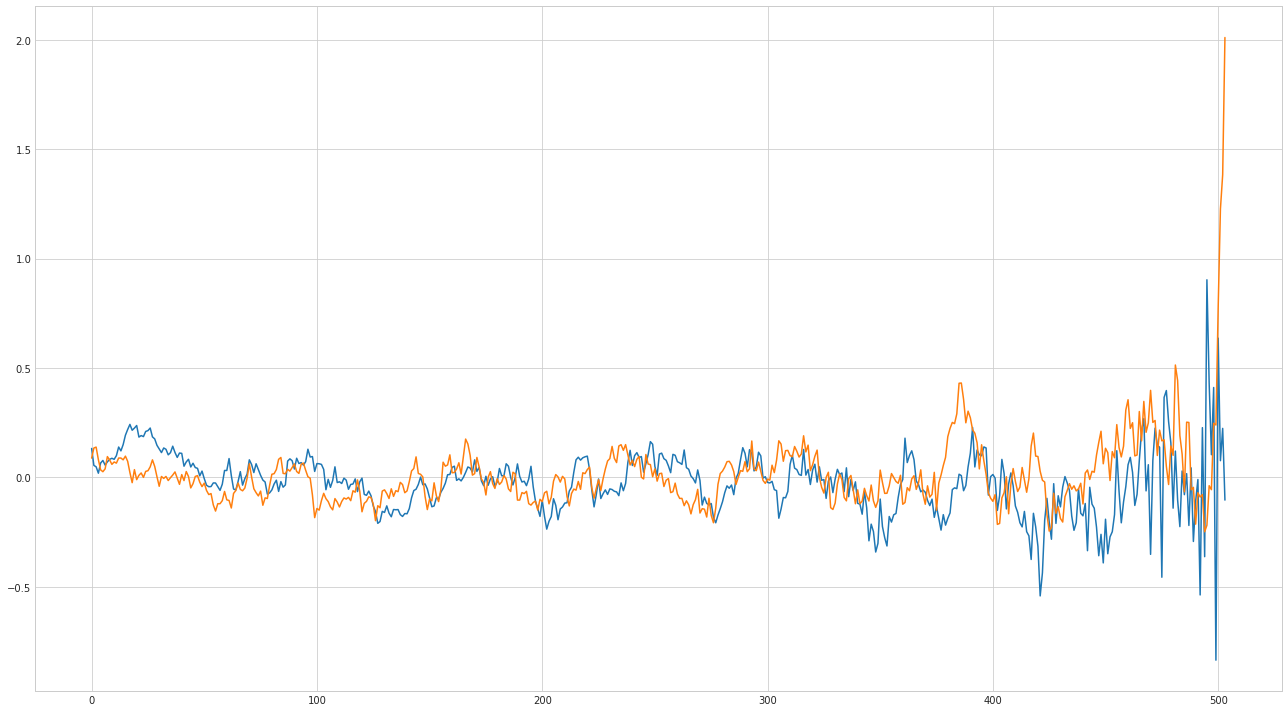

In [21]:
temp_cross1 = sm.tsa.stattools.ccf(df_00_sb.iloc[0:w]['congestion'], df_01_sb.iloc[0:w]['congestion'], fft=True)
df_10_wb = df_10[df_10["direction"]=="WB"]
temp_cross2 = sm.tsa.stattools.ccf(df_00_sb.iloc[0:w]['congestion'], df_10_wb.iloc[0:w]['congestion'], fft=True)

plt.plot(range(w),temp_cross1)
plt.plot(range(w),temp_cross2)

In [22]:
print(df_00_sb.iloc[6]['congestion'])
print(df_01_sb.iloc[3]['congestion'])
print()

print(df_00_sb.iloc[60]['congestion'])
print(df_01_sb.iloc[57]['congestion'])

#Pretty clearly southbound congestion out of (0,0) is a function of the with delay of 1 hour(3 20 minute samples) from southbound (0,1)

65
46

97
58


In [23]:
df_10_wb = df_10[df_10["direction"]=="WB"]
print(df_10_wb.shape)
print(df_10_wb.head())

(13059, 7)
     row_id                 time  x  y direction  congestion  coord_sym
22       22  1991-04-01 00:00:00  1  0        WB          32         10
87       87  1991-04-01 00:20:00  1  0        WB          32         10
152     152  1991-04-01 00:40:00  1  0        WB          32         10
217     217  1991-04-01 01:00:00  1  0        WB          32         10
282     282  1991-04-01 01:20:00  1  0        WB          32         10


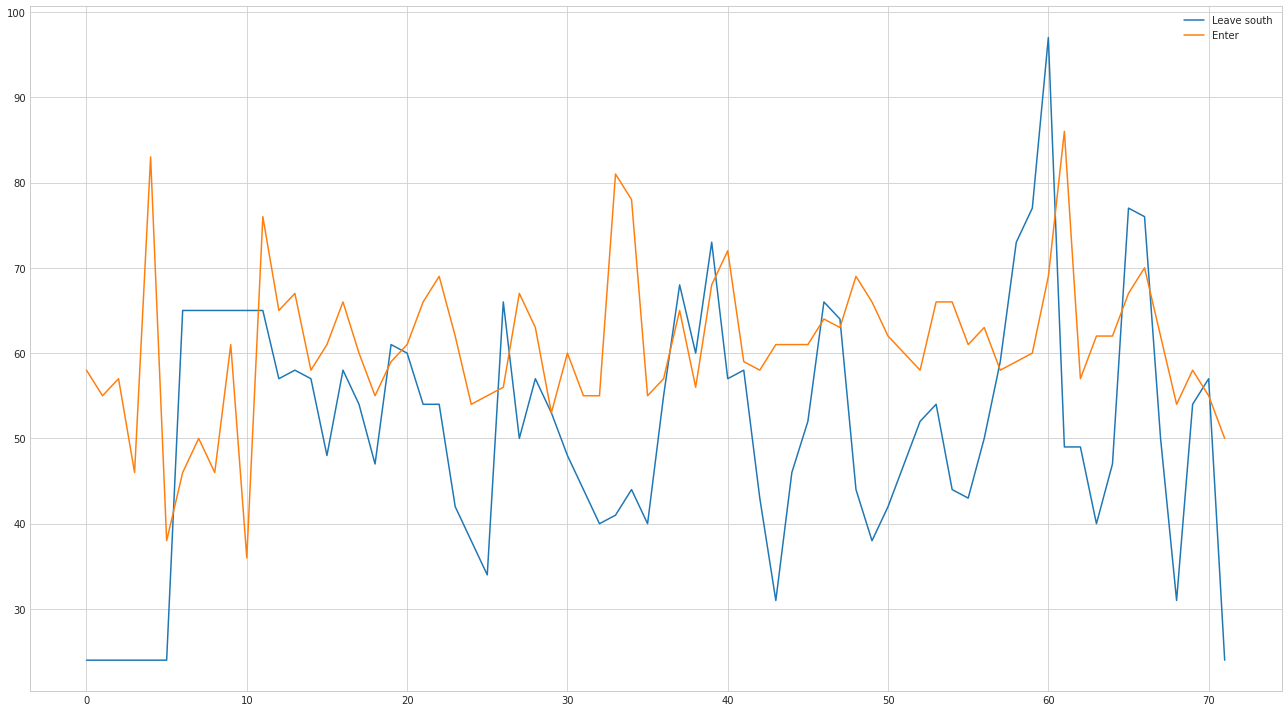

In [24]:
k = 24*3

x1 = df_00_sb['congestion'][0:k]
x2 = df_01_sb['congestion'][0:k]
x3 = df_10_wb['congestion'][0:k]
x4 = x2
x4.add(x3)

plt.plot(range(k),x1,label='Leave south')
plt.plot(range(k),x4,label='Enter')
#plt.plot(range(k),x2,label='Enter from north')
#plt.plot(range(k),x3,label='Enter from west')

plt.legend()
plt.show()

In [25]:
#my_test = TimeSeriesPlot(df_00_eb['congestion'] ,df_00_eb['time'] )
#df_00_tss = TimeSeriesStats(df_00_eb['congestion'])

#print(df_00_tss.mean)
#print(df_00_tss.var)
#print(df_00_tss.min)
#print(df_00_tss.max)

#day_entries = 24*3
#df_00_eb['time'][0:day_entries+1]

#unique_dir = df_00['direction'].unique()
#print(unique_dir.shape)
#print(unique_dir)